Vanessa Türker, Data Science MyDailyImpact, 24.02.25

# MyDailyImpact - Analysis and prediction of user behaviour in relation to activity



Background: Based on our own data, as the app is not yet online, we created our own data set for the analysis with the kind support of the mentor: synthetic_activity_dataset-v0.csv

The following steps were taken:

### Recipe Dataset Creation:

We define 50 unique dish names and a mapping of ingredients to possible plant-based substitutes.

For each dish, we generate a non-empty list of 3–6 ingredients.

For each ingredient, we assign a random portion size (in grams) and a random carbon footprint value (kg CO₂e).

The substitutions list is aligned with the ingredients list (using a substitute when available, or None).

This will need to be fixed in the future. Ingredient lists are not realistic.

### Activity Log Generation:

Six personas are defined with specific parameters (e.g., record count, weight/height ranges, home country, dish preferences, meal type distribution, and substitution probability).

For each record, a unique record_id, user profile fields, and a timestamp (within a meal-type-specific time window over the past 2 years) are generated.

A recipe is sampled from the recipe dataset (filtered by dish preferences when possible), and its fields are assigned to the record.

Additional fields like substitutions_made, hunger_rating, meal_rating, and geo_location are also generated.

This process creates a complete activity log record with all 16 fields.

### Next Steps:

The next step is to carry out a ‘churn prediction’. 

As all users are active and there is no database, a different approach is taken. This focuses on user inactivity, which in the worst case could lead to users leaving the platform. With the prediction of users at risk, a marketing department, for example, could take countermeasures and activate the user through email marketing or push messages.

### Data analysis


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read CSV
df = pd.read_csv('data/synthetic_activity_dataset-v0.csv')

# Show head
print(df.head())


   record_id       user_id   activity_timestamp  weight  height country_of_residence         dish_name  meal_type                                          ingredient_list                               substitutions_list  substitutions_made            carbon_footprint_original                   portion_size  hunger_rating  meal_rating        geo_location
0  rec_00369     Fit Felix  2023-02-18 09:32:24    71.5   176.3          Netherlands      Quinoa Salad  Breakfast                  ['onion', 'beef', 'yogurt', 'mushroom']         [None, 'seitan', 'coconut yogurt', None]                   0             [0.42, 4.57, 2.88, 3.62]           [256, 130, 152, 118]              4            4   (52.3622, 4.9089)
1  rec_01291     Diet Dani  2023-02-18 12:11:06    80.8   170.2                Italy  Zucchini Noodles      Lunch                       ['salt', 'pork', 'yogurt', 'fish']  [None, 'jackfruit', 'coconut yogurt', 'tempeh']                   0              [4.19, 0.9, 1.84, 3.38]           [

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   record_id                  1900 non-null   object 
 1   user_id                    1900 non-null   object 
 2   activity_timestamp         1900 non-null   object 
 3   weight                     1900 non-null   float64
 4   height                     1900 non-null   float64
 5   country_of_residence       1900 non-null   object 
 6   dish_name                  1900 non-null   object 
 7   meal_type                  1900 non-null   object 
 8   ingredient_list            1900 non-null   object 
 9   substitutions_list         1900 non-null   object 
 10  substitutions_made         1900 non-null   int64  
 11  carbon_footprint_original  1900 non-null   object 
 12  portion_size               1900 non-null   object 
 13  hunger_rating              1900 non-null   int64

In [27]:
df.nunique()

record_id                    1900
user_id                         6
activity_timestamp           1899
weight                        221
height                        191
country_of_residence            6
dish_name                      48
meal_type                       3
ingredient_list                49
substitutions_list             46
substitutions_made              2
carbon_footprint_original      49
portion_size                   49
hunger_rating                   5
meal_rating                     4
geo_location                 1899
dtype: int64

In [28]:
df.describe()

,weight,height,substitutions_made,hunger_rating,meal_rating
count,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,72.676789,172.247053,0.372632,3.450000,3.876316
std,8.889483,5.636173,0.483632,0.740838,0.672930
min,55.000000,163.000000,0.000000,1.000000,2.000000
25%,61.700000,167.600000,0.000000,3.000000,3.000000
50%,76.300000,170.800000,0.000000,3.000000,4.000000
75%,79.400000,178.200000,1.000000,4.000000,4.000000
max,85.000000,182.000000,1.000000,5.000000,5.000000


Copy of Dataset

In [29]:
# Create a copy of the data file as a backup

df_copy = df.copy()

Display options

In [30]:
from IPython.display import display

# Jupyter Notebook display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)

# Show DataFrame
display(df)


,record_id,user_id,activity_timestamp,weight,height,country_of_residence,dish_name,meal_type,ingredient_list,substitutions_list,substitutions_made,carbon_footprint_original,portion_size,hunger_rating,meal_rating,geo_location
0,rec_00369,Fit Felix,2023-02-18 09:32:24,71.5,176.3,Netherlands,Quinoa Salad,Breakfast,"['onion', 'beef', 'yogurt', 'mushroom']","[None, 'seitan', 'coconut yogurt', None]",0,"[0.42, 4.57, 2.88, 3.62]","[256, 130, 152, 118]",4,4,"(52.3622, 4.9089)"
1,rec_01291,Diet Dani,2023-02-18 12:11:06,80.8,170.2,Italy,Zucchini Noodles,Lunch,"['salt', 'pork', 'yogurt', 'fish']","[None, 'jackfruit', 'coconut yogurt', 'tempeh']",0,"[4.19, 0.9, 1.84, 3.38]","[147, 121, 166, 212]",3,3,"(41.9106, 12.4873)"
2,rec_00437,Fit Felix,2023-02-18 12:42:09,74.4,179.5,Netherlands,Quinoa Salad,Lunch,"['onion', 'beef', 'yogurt', 'mushroom']","[None, 'seitan', 'coconut yogurt', None]",1,"[0.42, 4.57, 2.88, 3.62]","[256, 130, 152, 118]",3,5,"(52.3655, 4.8923)"
3,rec_01236,Diet Dani,2023-02-18 18:10:54,80.2,169.0,Italy,Smoothie Bowl,Dinner,"['salt', 'spinach', 'cheese']","[None, None, 'vegan cheese']",1,"[0.89, 4.77, 4.62]","[89, 145, 245]",3,3,"(41.8916, 12.513)"
4,rec_01627,Travel Terry,2023-02-19 20:52:12,79.8,181.6,Japan,Vegan Chili,Dinner,"['broccoli', 'rice', 'tofu', 'chicken', 'fish', 'beef']","[None, None, None, 'tofu', 'tempeh', 'seitan']",1,"[0.28, 1.91, 2.81, 2.21, 0.3, 1.89]","[291, 276, 226, 281, 88, 189]",4,4,"(48.8488, 2.3658)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,rec_00441,Fit Felix,2025-02-15 09:08:08,74.6,179.2,Netherlands,Quinoa Salad,Breakfast,"['onion', 'beef', 'yogurt', 'mushroom']","[None, 'seitan', 'coconut yogurt', None]",1,"[0.42, 4.57, 2.88, 3.62]","[256, 130, 152, 118]",3,4,"(52.383, 4.9104)"
1896,rec_01064,Budget Billie,2025-02-15 09:38:55,61.0,163.9,India,Simple Pasta,Breakfast,"['beef', 'pasta', 'broccoli', 'fish', 'tomato']","['seitan', None, None, 'tempeh', None]",0,"[3.13, 4.32, 2.93, 3.55, 0.32]","[70, 191, 125, 262, 210]",5,3,"(12.9851, 77.6131)"
1897,rec_00113,Hardcore Henrietta,2025-02-15 13:33:24,82.1,170.2,Germany,Protein Pasta,Lunch,"['chicken', 'pepper', 'yogurt']","['tofu', None, 'coconut yogurt']",1,"[0.6, 3.73, 2.77]","[107, 85, 238]",4,5,"(52.5137, 13.3992)"
1898,rec_00089,Hardcore Henrietta,2025-02-15 13:40:50,75.4,173.7,Germany,Protein Pasta,Lunch,"['chicken', 'pepper', 'yogurt']","['tofu', None, 'coconut yogurt']",0,"[0.6, 3.73, 2.77]","[107, 85, 238]",4,5,"(52.5145, 13.417)"


## Churn Prediction

### Steps for creating a churn column:

Here we want to predict how likely a user is to leave the platform. Since we don't have ‘churn’ data as a target so far, this column is created based on the following considerations:

To measure inactivity, we calculate the time intervals between the logs. As this is random data, we consider the time span of 14 days to be relevant.

So we initially assume a period of 14 days during which the user is inactive. As this is randomly generated data (up to 450 logs in total within 2 years), we may adjust this assumption again depending on the results. This value would certainly have to be adjusted for an app used later in the real world.

In [31]:
# the last date used in the Dataset
last_activity_date = df['activity_timestamp'].max()

# the last date used in the Dataset
print("The last date used is:", last_activity_date)

The last date used is: 2025-02-16 13:55:09


In [32]:
# Convert the activity_timestamp column to datetime format
df['activity_timestamp'] = pd.to_datetime(df['activity_timestamp'])

# Sort the DataFrame by user_id and activity_timestamp
df = df.sort_values(by=['user_id', 'activity_timestamp'])

# Calculate the time interval between logs for each user
df['previous_activity'] = df.groupby('user_id')['activity_timestamp'].shift(1)
df['inactivity_duration'] = (df['activity_timestamp'] - df['previous_activity']).dt.days


In [33]:
# Check for incorrect conversions
if df['inactivity_duration'].isnull().values.any():
    df['inactivity_duration'].fillna(0, inplace=True)  # Nullwerte durch 0 ersetzen

# Find maximum and minimum inactivity value
max_inactivity = df['inactivity_duration'].max()
min_inactivity = df['inactivity_duration'].min()

# Display of the maximum and minimum inactivity value
print("Maximum inactivity (in days):", max_inactivity)
print("Minimal nactivity (in days):", min_inactivity)

Maximum inactivity (in days): 17.0
Minimal nactivity (in days): 0.0


C:\Users\Vanessa\AppData\Local\Temp\ipykernel_15492\3224093890.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['inactivity_duration'].fillna(0, inplace=True)  # Nullwerte durch 0 ersetzen


In [34]:
# Definition of an inactivity threshold (e.g. 14 days)
inactivity_threshold = 14
df['inactive'] = df['inactivity_duration'] > inactivity_threshold

# Show DataFrame
print(df)

      record_id        user_id  activity_timestamp  weight  height country_of_residence           dish_name  meal_type                                            ingredient_list                                             substitutions_list  substitutions_made             carbon_footprint_original                 portion_size  hunger_rating  meal_rating        geo_location   previous_activity  inactivity_duration  inactive
13    rec_00945  Budget Billie 2023-02-21 20:12:12    58.7   164.9                India  Ramen with Veggies     Dinner  ['garlic', 'yogurt', 'milk', 'spinach', 'quinoa', 'beef']  [None, 'coconut yogurt', 'almond milk', None, None, 'seitan']                   0  [0.88, 3.43, 3.02, 1.99, 3.02, 2.39]  [243, 62, 270, 78, 89, 210]              4            3   (12.954, 77.5933)                 NaT                  0.0     False
26    rec_01139  Budget Billie 2023-02-26 20:43:05    58.3   166.1                India  Ramen with Veggies     Dinner  ['garlic', 'yogurt', 'milk

### Count the number of inactive users per country & weight/height

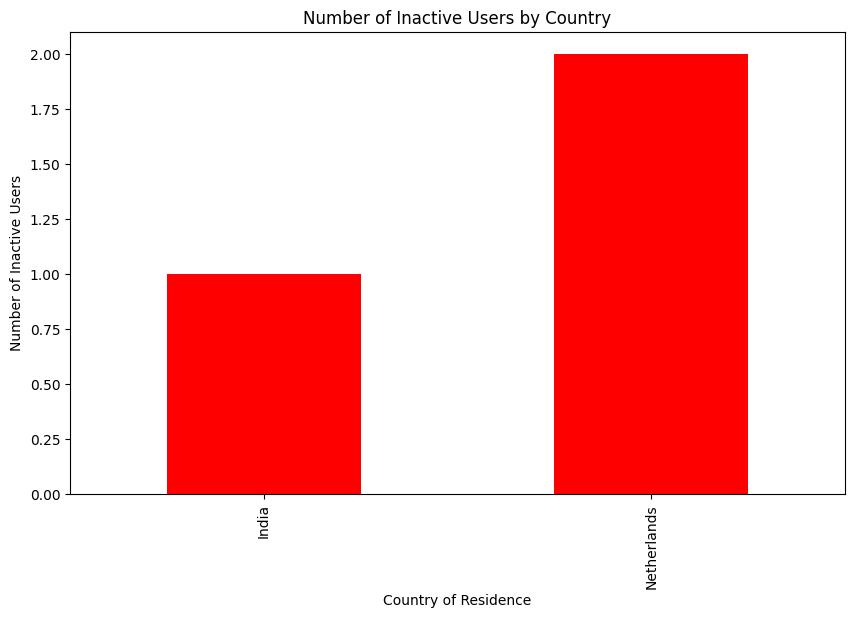

In [ ]:
# Count the number of inactive users per country
inactive_counts = df[df['inactive']].groupby('country_of_residence').size()

# Balkendiagramm erstellen
inactive_counts.plot(kind='bar', color='red', figsize=(10, 6))
plt.xlabel('Country of Residence')
plt.ylabel('Number of Inactive Users')
plt.title('Number of Inactive Users by Country')
plt.show()

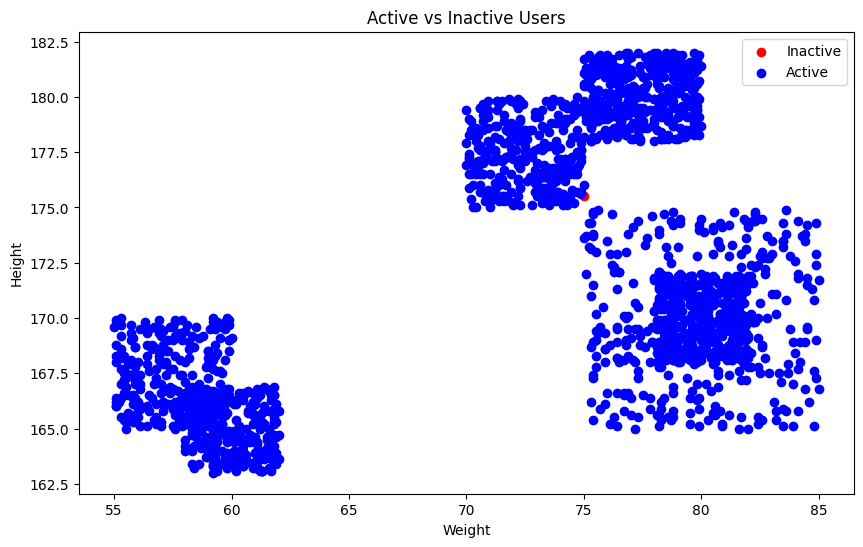

In [36]:
# Streudiagramm erstellen
plt.figure(figsize=(10, 6))
plt.scatter(df[df['inactive']]['weight'], df[df['inactive']]['height'], color='red', label='Inactive')
plt.scatter(df[~df['inactive']]['weight'], df[~df['inactive']]['height'], color='blue', label='Active')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Active vs Inactive Users')
plt.legend()
plt.show()

### Data preparation for predicting

In [14]:
# Change True to 1 and False to 0 in the inactive column
df['inactive'] = df['inactive'].astype(int)

# Show DataFrame
print(df)

      record_id        user_id  activity_timestamp  weight  height country_of_residence           dish_name  meal_type                                            ingredient_list                                             substitutions_list  substitutions_made             carbon_footprint_original                 portion_size  hunger_rating  meal_rating        geo_location   previous_activity  inactivity_duration  inactive
13    rec_00945  Budget Billie 2023-02-21 20:12:12    58.7   164.9                India  Ramen with Veggies     Dinner  ['garlic', 'yogurt', 'milk', 'spinach', 'quinoa', 'beef']  [None, 'coconut yogurt', 'almond milk', None, None, 'seitan']                   0  [0.88, 3.43, 3.02, 1.99, 3.02, 2.39]  [243, 62, 270, 78, 89, 210]              4            3   (12.954, 77.5933)                 NaT                  0.0         0
26    rec_01139  Budget Billie 2023-02-26 20:43:05    58.3   166.1                India  Ramen with Veggies     Dinner  ['garlic', 'yogurt', 'milk

### Define feature selection and target variable

In [15]:
features = ['weight', 'height', 'country_of_residence', 'meal_type', 'hunger_rating', 'meal_rating']
X = pd.get_dummies(df[features])
y = df['inactive']

 ### Heatmap with target variable

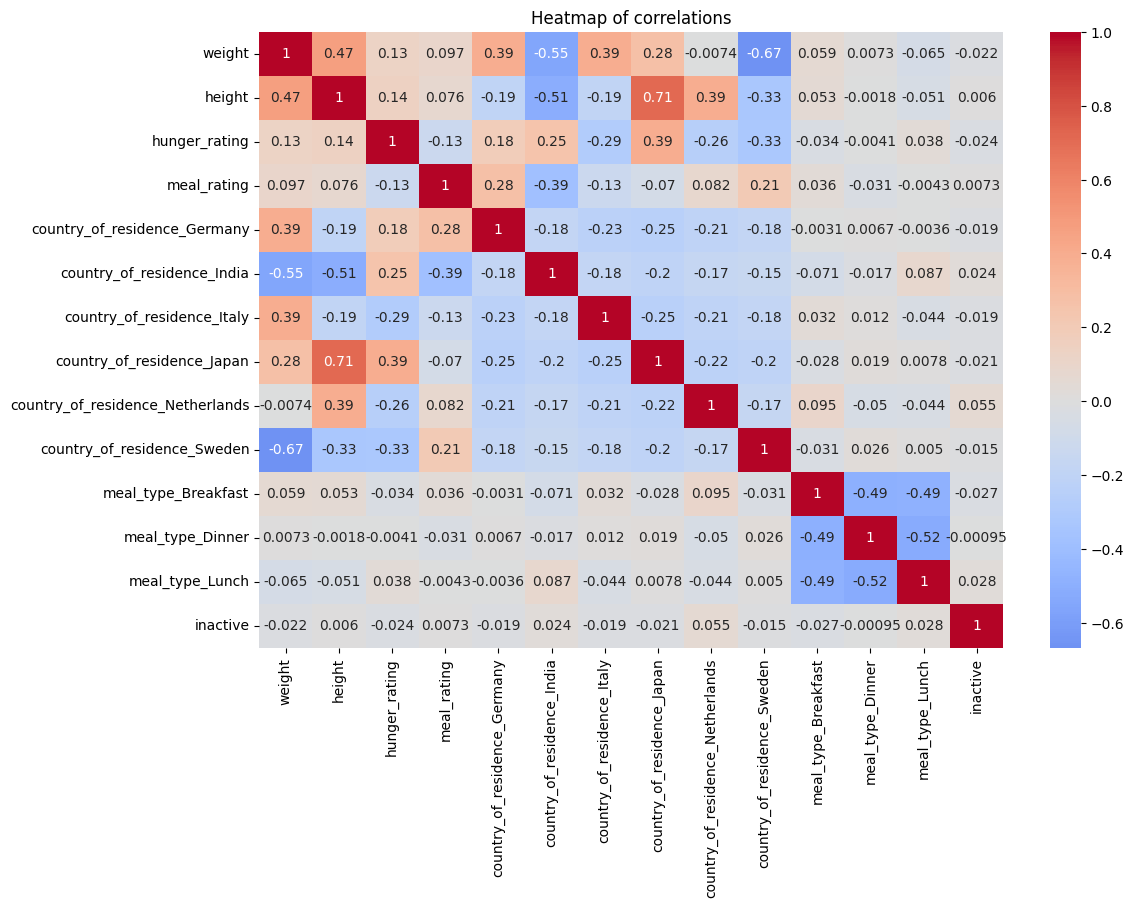

In [16]:
# Heatmap with target variable

import seaborn as sns
import matplotlib.pyplot as plt

# Kombiniere die Features und das Ziel in einem DataFrame
df_combined = pd.concat([X, y], axis=1)

# Korrelationen berechnen
correlation_matrix = df_combined.corr()

# Heatmap erstellen
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of correlations')
plt.show()


### Heatmap with features (without target)

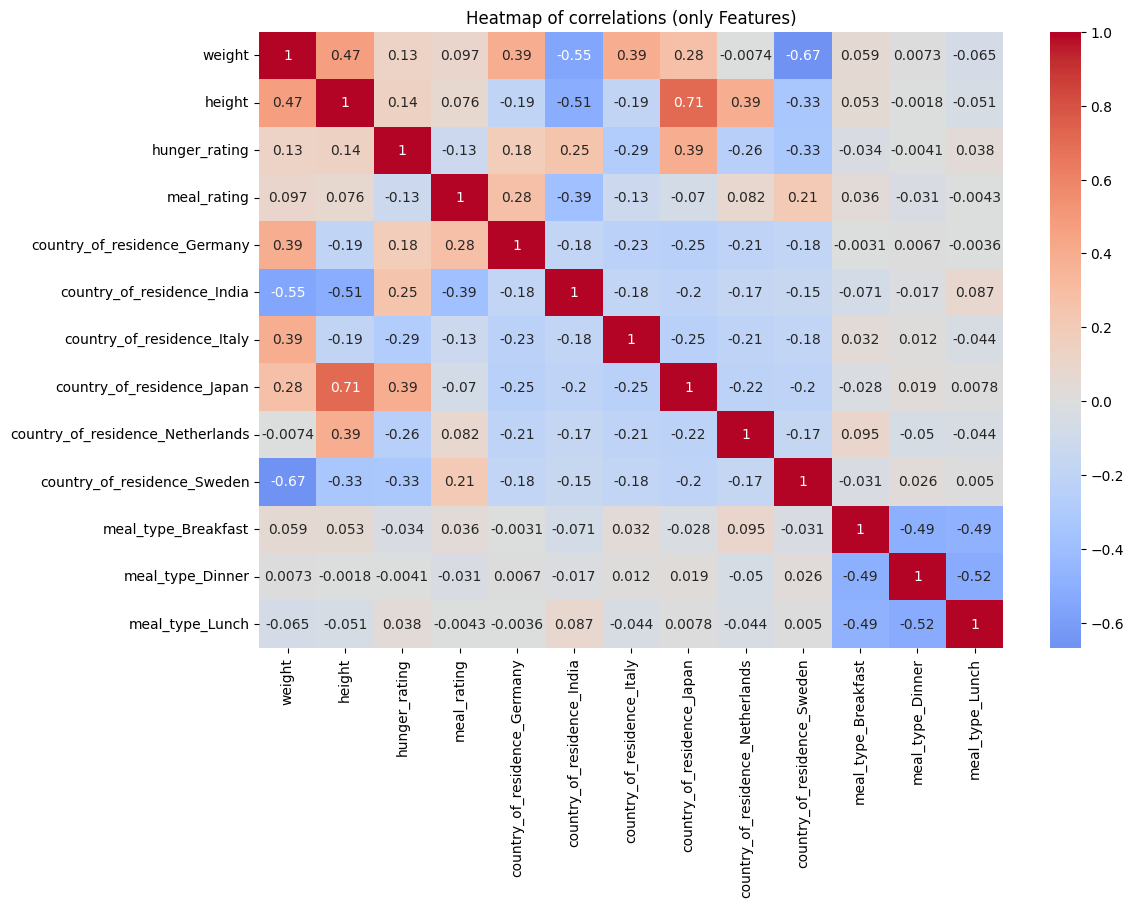

In [17]:
# heatmap with features (without target variable)

# Korrelationen berechnen
correlation_matrix2 = X.corr()

# Heatmap erstellen
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of correlations (only Features)')
plt.show()


## Baseline model with logistic regression

In [18]:
# Baseline model with logistic regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Data split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Prediction
y_pred_logreg = logreg.predict(X_test)

# Calculate metrics
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)

# show results
print(f'Accuracy of Logistic Regression: {accuracy_logreg}')
print(f'ROC-AUC: {roc_auc_logreg}')
print('Confusion Matrix:')
print(conf_matrix_logreg)


Accuracy of Logistic Regression: 0.9964912280701754
ROC-AUC: 0.5
Confusion Matrix:
[[568   0]
 [  2   0]]


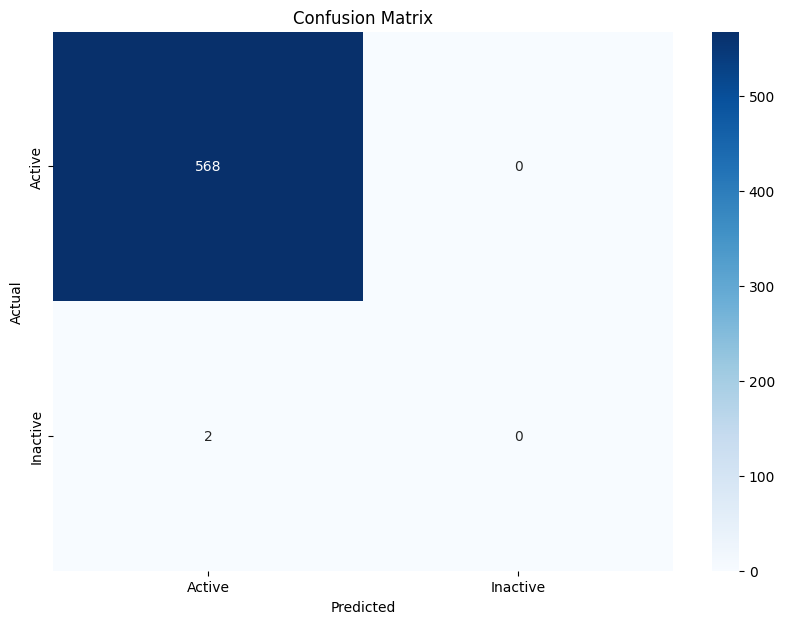

In [19]:
# Visualisiation of Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Random Forest model

In [20]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Data split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediction
y_pred_rf = clf.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# show results
print(f'Accuracy of Random Forest: {accuracy_rf}')
print(f'ROC-AUC: {roc_auc_rf}')
print('Confusion Matrix:')
print(conf_matrix_rf)

Accuracy of Random Forest: 0.9964912280701754
ROC-AUC: 0.5
Confusion Matrix:
[[568   0]
 [  2   0]]


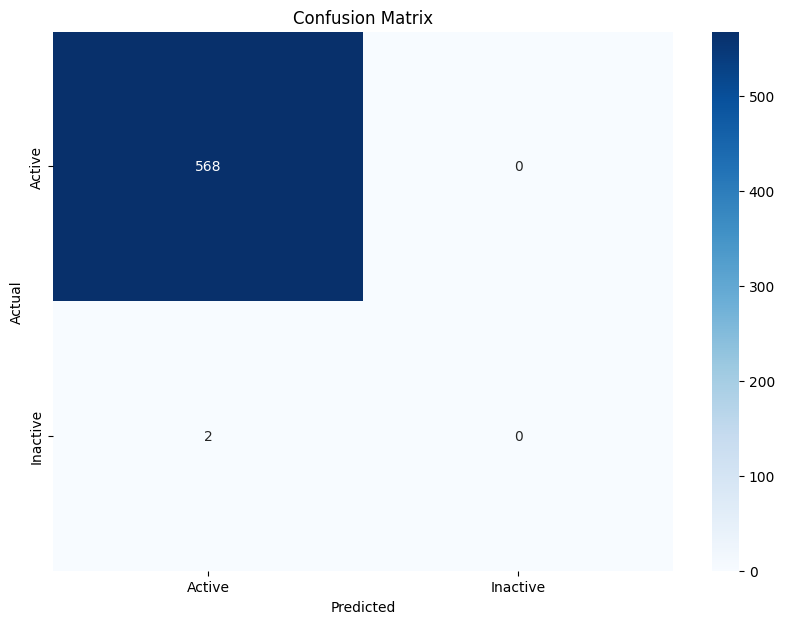

In [21]:
# Visualisiation of Confusion Matrix for Random Forest
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Feature Importance

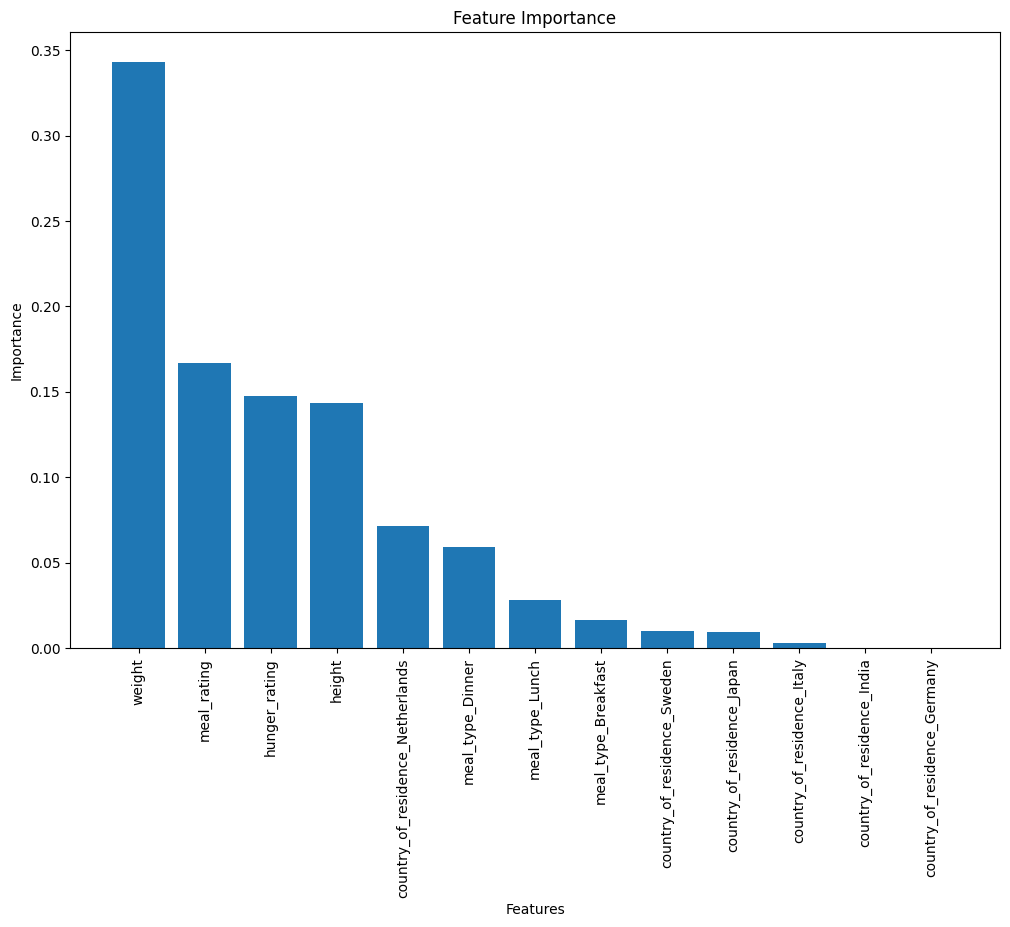

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


# CONCLUSION

Unfortunately, it is not possible to carry out any meaningful precision engineering with the data provided. The aim here was rather to show the general way of analysing the data. 

Presumably also due to the data situation, there is no difference between the two models; it is more likely to be an overfitting. 

With real data, the approach is promising and can provide valuable insights, e.g. for a marketing department that wants to activate inactive users through email marketing or push messages.